In [1]:

%pprint
%matplotlib inline
import sys
sys.path.insert(1, '../py')
from jobpostlib import (crf, cu, datetime, duration, hau, hc, humanize, ihu, lru, nu, osp, scrfcu, slrcu, ssgdcu, su, t0, time, winsound, wsu)
import os
from pandas import DataFrame

freq = 990

Pretty printing has been turned OFF
======== Neo4j/4.4.7 ========
Utility libraries created in 11 seconds


In [2]:

# Check if the slrcu has built its parts-of-speech logistic regression elements
# Parts-of-speech logistic regression elements is normally built in 1 hour, 27 minutes and 21 seconds
t1 = time.time()
if not hasattr(slrcu, 'pos_predict_percent_fit_dict'):
    slrcu.build_pos_logistic_regression_elements(sampling_strategy_limit=None, verbose=True)
if hasattr(slrcu, 'pos_predict_percent_fit_dict'):
    print('predict_single is available')
else:
    print('predict_single is not available')
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Parts-of-speech logistic regression elements built in {duration_str}')

I have 49,102 labeled parts of speech in here
predict_single is available
Parts-of-speech logistic regression elements built in 6 seconds


In [3]:

# Check if the scrfcu has built its parts-of-speech conditional random field elements
# Parts-of-speech CRF elements normally built in 29 minutes and 57 seconds
t1 = time.time()
if not hasattr(scrfcu, 'pos_symbol_crf'):
    scrfcu.build_pos_conditional_random_field_elements(verbose=True)
if hasattr(scrfcu, 'pos_predict_percent_fit_dict'):
    print('predict_single is now available')
else:
    print('predict_single is not available')
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Parts-of-speech conditional random field elements built in {duration_str}')

predict_single is now available
Parts-of-speech conditional random field elements built in 1 second


In [4]:

# Check if the ssgdcu has built its parts-of-speech stochastic gradient decent elements
t1 = time.time()
if not hasattr(ssgdcu, 'pos_predict_percent_fit_dict'):
    ssgdcu.build_pos_stochastic_gradient_descent_elements(sampling_strategy_limit=None, verbose=True)
if hasattr(ssgdcu, 'pos_predict_percent_fit_dict'): print('predict_single is now available')
else: print('predict_single is not available')
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Parts-of-speech stochastic gradient descent elements built in {duration_str}')

I have 49,102 labeled parts of speech in here
predict_single is now available
Parts-of-speech stochastic gradient descent elements built in 9 seconds


In [5]:

# Check if the crf has built its parts-of-speech classifier
# POS classifier normally trained in 15 hours, 42 minutes and 41 seconds
t1 = time.time()
if not hasattr(crf, 'CRF'): crf.build_pos_conditional_random_field_elements(verbose=True)
if hasattr(crf, 'CRF'): print('predict_single is now available')
else: print('predict_single is not available')
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'POS classifier trained in {duration_str}')

predict_single is now available
POS classifier trained in 0 seconds


In [6]:

# Check if the lru has built its is-qualified classifier
t1 = time.time()
if not (hasattr(lru, 'ISQUALIFIED_LR') and hasattr(lru, 'ISQUALIFIED_CV')):
    lru.build_isqualified_logistic_regression_elements(sampling_strategy_limit=None, verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Is-qualified LR elements built in {duration_str}')

I have 424,879 is-qualified vocabulary tokens in here
Is-qualified LR elements built in 6 seconds


In [7]:

# Train the isheader classifier
t1 = time.time()
ihu.build_pos_stochastic_gradient_descent_elements(verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Is-header classifier trained in {duration_str}')

I have 49,656 hand-labeled header htmls prepared
7 iterations seen during training fit for a total of 49,656 records trained
Is-header classifier trained in 6 seconds


In [8]:

winsound.Beep(freq, duration)
print(f'Last run on {datetime.now()}')

Last run on 2024-03-28 13:59:29.811630



---
# Training

In [45]:

# You need to run this again if you changed the
# qualification dictionary below or in another notebook
t1 = time.time()

# Keep the total retraining time to less than two minutes by adjusting the sampling strategy limit
lru.sync_basic_quals_dict(sampling_strategy_limit=None, verbose=False)

lru.retrain_isqualified_classifier(verbose=True)
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Is-qualified classifer retrained in {duration_str}')

I have 15,253 hand-labeled qualification strings in here
I have 498,069 is-qualified vocabulary tokens in here
Is-qualified classifer retrained in 1 minute and 44 seconds



---
# Inference

In [46]:

t1 = time.time()

# Loop through all the unset %fit values, set them if you can, break for help if you can't
quals_list, file_name = lru.infer_from_hunting_dataframe(fitness_threshold=3/4, verbose=True)
winsound.Beep(freq, duration)

Basic Qualifications for Azure Engineer III Remote:
*quals_list[0] = "<li>Comprehensive experience in architecting and delivering Cloud solutions (eg AWS, Azure, Google)</li>" (1.0)
*quals_list[1] = "<li>Network protocols and security standards (may require)</li>" (0.9297)
*quals_list[2] = "<li>Strong data warehouse/business intelligence delivery experience (may require)</li>" (0.0)
*quals_list[3] = "<li>Microsoft Azure and DataBricks Solution Architect certification(s) preferred</li>" (0.0)
*quals_list[4] = "<li>Strong knowledge of best practices relative to application development or infrastructure standards</li>" (1.0)
*quals_list[5] = "<li>Advanced system configuration skills</li>" (1.0)
*quals_list[6] = "<li>Proficient with Infrastructure as Code (IaC) and configuration management tools (eg vRealize Automation, vRealize Orchestrator, Chef, Terraform)</li>" (0.9998)
*quals_list[7] = "<li>Experience with Business Intelligence, Analytic tools such as Informatica, MicroStrategy, SSRS 

In [ ]:
raise

In [44]:

# Manually label the unscored qual
qualification_str = quals_list[15]
print(qualification_str); basic_quals_dict = nu.load_object('basic_quals_dict')
print(str(basic_quals_dict[qualification_str]) + '\n' if(qualification_str in basic_quals_dict) else '', end='')
basic_quals_dict[qualification_str] = 1
nu.store_objects(basic_quals_dict=basic_quals_dict)

<li> Data-driven with a commitment to process; drive/track consistent engagement process</li>
Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\basic_quals_dict.pkl



----
## Fix Parts-of-Speech and Quals for this posting

In [26]:

t1 = time.time()
file_path = os.path.join(cu.SAVES_HTML_FOLDER, file_name)
if os.path.isfile(file_path):
    child_strs_list = hau.get_child_strs_from_file(file_name=file_name)
    cu.ensure_filename(file_name, verbose=False)
    cu.populate_from_child_strings(child_strs_list, file_name, verbose=False)
    print(file_name)
    child_tags_list = hau.get_child_tags_list(child_strs_list)
    feature_dict_list = cu.get_feature_dict_list(child_tags_list, child_strs_list)
    feature_tuple_list = []
    for feature_dict in feature_dict_list:
        feature_tuple_list.append(hc.get_feature_tuple(
            feature_dict, pos_lr_predict_single=slrcu.predict_single, pos_crf_predict_single=scrfcu.predict_single,
            pos_sgd_predict_single=ssgdcu.predict_single
        ))
    crf_list = crf.CRF.predict_single(crf.sent2features(feature_tuple_list))
duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'CRF and child strings list recreated in {duration_str}')

4c0b6386d485a3d7_Senior_Data_Conversion_Programmer_Eagle_Remote_Indeed_com.html
CRF and child strings list recreated in 3 minutes and 5 seconds


In [27]:

db_pos_list = []
for navigable_parent in child_strs_list:
    db_pos_list = cu.append_parts_of_speech_list(navigable_parent, pos_list=db_pos_list)
pos_list, indices_list = su.visualize_basic_quals_section(crf_list, child_strs_list, db_pos_list=db_pos_list, verbose=True)
winsound.Beep(freq, duration)

['O-TS', 'O-IP', 'H-IP', 'O-IP', 'O-RQ', 'O-IP', 'O-IP', 'O-IP', 'O-IP', 'O-IP', 'O-ER', 'O-IP', 'O-IP', 'O-IP', 'O-IP', 'O-TS', 'O-IP', 'O-IP', 'O-IP', 'O-SP', 'O-SP', 'H-JD', 'O-TS', 'O-IP', 'O-OL', 'O-OL', 'O-IP', 'H-SP', 'O-IP', 'O-SP', 'O-SP', 'O-SP', 'O-SP', 'O-SP', 'O-SP', 'O-SP', 'O-IP', 'H-O', 'O-OL', 'H-RQ', 'O-OL', 'O-PD', 'O-PD', 'H-RQ', 'O-RQ', 'O-JT', 'O-CS', 'H-RQ', 'H-RQ', 'H-RQ', 'O-RQ', 'H-SP', 'O-SP', 'H-RQ', 'H-JT', 'O-TS', 'H-TS', 'O-TS', 'O-TS', 'O-RQ', 'O-TS', 'O-RQ', 'O-TS', 'H-RQ', 'O-RQ', 'O-RQ', 'O-RQ', 'O-RQ', 'O-RQ', 'O-PQ', 'O-RQ', 'O-RQ', 'O-RQ', 'O-RQ', 'O-RQ', 'O-RQ', 'O-RQ', 'H-RQ', 'O-IP', 'O-IP', 'O-RQ', 'O-PQ', 'O-RQ', 'H-CS', 'O-TS', 'H-CS', 'O-CS', 'O-CS', 'O-CS', 'H-LN', 'O-IP', 'O-CS', 'O-SP', 'O-SP', 'O-IP']
[4, 10, 44, 50, 59, 61, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 80, 82]


[4, 10, 44, 50, 59, 61, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 75, 76, 80, 82]


In [ ]:
raise

In [34]:

import re

basic_quals_dict = nu.load_object('basic_quals_dict')
column_name = 'is_interview_procedure'
for idx in list(range(49, 51)) + list(range(49, 51)):
    child_str = child_strs_list[idx]; pos_symbol = pos_list[idx]
    def do_cypher_tx(tx, navigable_parent, verbose=False):
        cypher_str = '''
            MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
            ''' + cu.return_everything_str + ';'
        results_list = tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})
        return [dict(record.items()) for record in results_list]
    with cu.driver.session() as session: row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=False)
    if (row_objs_list[0][column_name] != True):
        print(str(basic_quals_dict[child_str]) + '\n' if(child_str in basic_quals_dict) else '', end='')
        print(f'{idx} {pos_symbol}) {child_str}')
        def do_cypher_tx(tx, navigable_parent, verbose=False):
            cypher_str = f'''
                MATCH (np:NavigableParents {{navigable_parent: $navigable_parent}})
                SET
                    np.is_task_scope = {str(column_name == 'is_task_scope').lower()},
                    np.is_minimum_qualification = {str(column_name == 'is_minimum_qualification').lower()},
                    np.is_preferred_qualification = {str(column_name == 'is_preferred_qualification').lower()},
                    np.is_educational_requirement = {str(column_name == 'is_educational_requirement').lower()},
                    np.is_legal_notification = {str(column_name == 'is_legal_notification').lower()},
                    np.is_other = {str(column_name == 'is_other').lower()},
                    np.is_corporate_scope = {str(column_name == 'is_corporate_scope').lower()},
                    np.is_job_title = {str(column_name == 'is_job_title').lower()},
                    np.is_office_location = {str(column_name == 'is_office_location').lower()},
                    np.is_job_duration = {str(column_name == 'is_job_duration').lower()},
                    np.is_supplemental_pay = {str(column_name == 'is_supplemental_pay').lower()},
                    np.is_interview_procedure = {str(column_name == 'is_interview_procedure').lower()},
                    np.is_posting_date = {str(column_name == 'is_posting_date').lower()}
                ''' + cu.return_everything_str + ';'
            return [dict(record.items()) for record in tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})]
        with cu.driver.session() as session: row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=False)
    if re.sub(r'\s*</\w+>', '', child_str).endswith(':') and (row_objs_list[0]['is_header'] != True):
        print(str(basic_quals_dict[child_str]) + '\n' if(child_str in basic_quals_dict) else '', end='')
        print(f'{idx} {pos_symbol}) {child_str}')
        def do_cypher_tx(tx, navigable_parent, verbose=False):
            cypher_str = f'''
                MATCH (np:NavigableParents {{navigable_parent: $navigable_parent}})
                SET
                    np.is_header = true
                ''' + cu.return_everything_str + ';'
            return [dict(record.items()) for record in tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})]
        with cu.driver.session() as session: row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=False)

49 H-RQ) <b>Recruiter </b>
50 O-RQ) <p>Olagbaju, Fehintola </p>


In [109]:

import re

basic_quals_dict = nu.load_object('basic_quals_dict')
for idx in [70]:
    child_str = child_strs_list[idx]; pos_symbol = pos_list[idx]
    print(str(basic_quals_dict[child_str]) + '\n' if(child_str in basic_quals_dict) else '', end='')
    print(f'{idx} {pos_symbol}) {child_str}')
    def do_cypher_tx(tx, navigable_parent, verbose=False):
        cypher_str = f'''
            MATCH (np:NavigableParents {{navigable_parent: $navigable_parent}})
            SET
                np.is_header = true
            ''' + cu.return_everything_str + ';'
        return [dict(record.items()) for record in tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})]
    with cu.driver.session() as session: row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=False)

70 O-RQ) <p> The Expert Network seeks passionate RevOps professionals with:</p>


In [124]:

# Display the context of an individual child string
idx = 38
print(indices_list); child_str = child_strs_list[idx]; pos_symbol = pos_list[idx]; basic_quals_dict = nu.load_object('basic_quals_dict')
print(str(basic_quals_dict[child_str]) + '\n' if(child_str in basic_quals_dict) else '', end='')
print(f'{idx} {pos_symbol}) {child_str}')

[24, 25, 26, 27, 28, 29, 36, 37, 38, 46]
38 O-RQ) <li> Minimum 2 years of experience.</li>


In [92]:

# Hand-label this particular child string in the quals dictionary
basic_quals_dict = nu.load_object('basic_quals_dict')
basic_quals_dict[child_str] = 1
nu.store_objects(basic_quals_dict=basic_quals_dict); print(f'"{child_str}" in basic_quals_dict: {basic_quals_dict[child_str]}')

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\job-hunting\saves\pkl\basic_quals_dict.pkl
"<div>
     Experience being an effective member in a mixed team of technical and non-technical colleagues
   </div>" in basic_quals_dict: 1


In [125]:

def do_cypher_tx(tx, navigable_parent, verbose=False):
    cypher_str = '''
        MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
        SET
            np.is_header = false,
            np.is_task_scope = false,
            np.is_minimum_qualification = false,
            np.is_preferred_qualification = false,
            np.is_educational_requirement = false,
            np.is_legal_notification = false,
            np.is_other = false,
            np.is_corporate_scope = false,
            np.is_job_title = false,
            np.is_office_location = false,
            np.is_job_duration = false,
            np.is_supplemental_pay = false,
            np.is_interview_procedure = true,
            np.is_posting_date = false
        ''' + cu.return_everything_str + ';'
    return [dict(record.items()) for record in tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})]
with cu.driver.session() as session: row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=False)
ihu.retrain_classifier(row_objs_list[0]['navigable_parent'], row_objs_list[0]['is_header'], verbose=False); row_objs_list

[{'navigable_parent': '<li> Minimum 2 years of experience.</li>', 'is_header': False, 'is_task_scope': False, 'is_minimum_qualification': False, 'is_preferred_qualification': False, 'is_legal_notification': False, 'is_job_title': False, 'is_office_location': False, 'is_job_duration': False, 'is_supplemental_pay': False, 'is_educational_requirement': False, 'is_interview_procedure': True, 'is_corporate_scope': False, 'is_posting_date': False, 'is_other': False}]

In [129]:

basic_quals_dict = nu.load_object('basic_quals_dict')
column_name = 'is_interview_procedure'
for idx in range(len(child_strs_list)):
    child_str = child_strs_list[idx]; pos_symbol = pos_list[idx]
    if '?' in child_str:
        def do_cypher_tx(tx, navigable_parent, verbose=False):
            cypher_str = '''
                MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
                ''' + cu.return_everything_str + ';'
            results_list = tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})
            return [dict(record.items()) for record in results_list]
        with cu.driver.session() as session: row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=False)
        if (row_objs_list[0][column_name] != True):
            print(str(basic_quals_dict[child_str]) + '\n' if(child_str in basic_quals_dict) else '', end='')
            print(f'{idx} {pos_symbol}) {child_str}')
            def do_cypher_tx(tx, navigable_parent, verbose=False):
                cypher_str = f'''
                    MATCH (np:NavigableParents {{navigable_parent: $navigable_parent}})
                    SET
                        np.is_task_scope = {str(column_name == 'is_task_scope').lower()},
                        np.is_minimum_qualification = {str(column_name == 'is_minimum_qualification').lower()},
                        np.is_preferred_qualification = {str(column_name == 'is_preferred_qualification').lower()},
                        np.is_educational_requirement = {str(column_name == 'is_educational_requirement').lower()},
                        np.is_legal_notification = {str(column_name == 'is_legal_notification').lower()},
                        np.is_other = {str(column_name == 'is_other').lower()},
                        np.is_corporate_scope = {str(column_name == 'is_corporate_scope').lower()},
                        np.is_job_title = {str(column_name == 'is_job_title').lower()},
                        np.is_office_location = {str(column_name == 'is_office_location').lower()},
                        np.is_job_duration = {str(column_name == 'is_job_duration').lower()},
                        np.is_supplemental_pay = {str(column_name == 'is_supplemental_pay').lower()},
                        np.is_interview_procedure = {str(column_name == 'is_interview_procedure').lower()},
                        np.is_posting_date = {str(column_name == 'is_posting_date').lower()}
                    ''' + cu.return_everything_str + ';'
                return [dict(record.items()) for record in tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})]
            with cu.driver.session() as session: row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=False)

69 O-RQ) <li>The hours required are in Central Time: Mondays and Wednesdays 6-9pm and fortnightly Saturdays 9am-5pm. Are you able to commit to this?</li>
70 O-IP) <li>The project dates are 11 March 2024 to 4 May 2024. Are you able to commit to this?</li>


In [448]:

# Show what's in the database already for this html string
def do_cypher_tx(tx, navigable_parent, verbose=False):
    cypher_str = '''
        MATCH (np:NavigableParents {navigable_parent: $navigable_parent})
        ''' + cu.return_everything_str + ';'
    results_list = tx.run(query=cypher_str, parameters={'navigable_parent': navigable_parent})
    return [dict(record.items()) for record in results_list]
with cu.driver.session() as session: row_objs_list = session.write_transaction(do_cypher_tx, navigable_parent=child_str, verbose=False)
row_objs_list

[{'navigable_parent': "<p>This position's responsibilities fall into eight basic areas:</p>", 'is_header': False, 'is_task_scope': True, 'is_minimum_qualification': False, 'is_preferred_qualification': False, 'is_legal_notification': False, 'is_job_title': False, 'is_office_location': False, 'is_job_duration': False, 'is_supplemental_pay': False, 'is_educational_requirement': False, 'is_interview_procedure': False, 'is_corporate_scope': False, 'is_posting_date': False, 'is_other': False}]


----
## Maintenance

,percent_fit,file_name,posting_url
0,1.0,4eeb9a388e80b439_Associate_Data_Scientist_Oper...,https://www.indeed.com/rc/clk/dl?jk=4eeb9a388e...
1,1.0,8854e7ff7ea2968f_Data_Science_Consultant_Lake_...,https://www.indeed.com/rc/clk/dl?jk=8854e7ff7e...
2,1.0,f311e251e658f0c8_Data_Operations_Analyst_Remot...,https://www.indeed.com/rc/clk/dl?jk=f311e251e6...
3,1.0,Gen_AI_Architect_Remote_Philadelphia_PA_Indeed...,https://www.indeed.com/pagead/clk/dl?mo=r&ad=-...
4,1.0,b982be6e0261d915_AI_Engineer_Fulltime_Remote_I...,https://www.indeed.com/rc/clk/dl?jk=b982be6e02...
...,...,...,...
65,0.8,06834c6cc203169c_Data_Scientist_Lititz_PA_1754...,https://www.indeed.com/rc/clk/dl?jk=06834c6cc2...
66,0.8,Python_Developer_Atlanta_GA_30339_Indeed_com.html,https://www.indeed.com/pagead/clk/dl?mo=r&ad=-...
67,0.8,f4503bdc3a1cc405_Python_Developer_AI_ML_Burban...,https://www.indeed.com/rc/clk/dl?jk=f4503bdc3a...
68,0.8,dbbd5b4ea65d8d61_Data_Scientist_with_power_BI_...,https://www.indeed.com/rc/clk/dl?jk=dbbd5b4ea6...


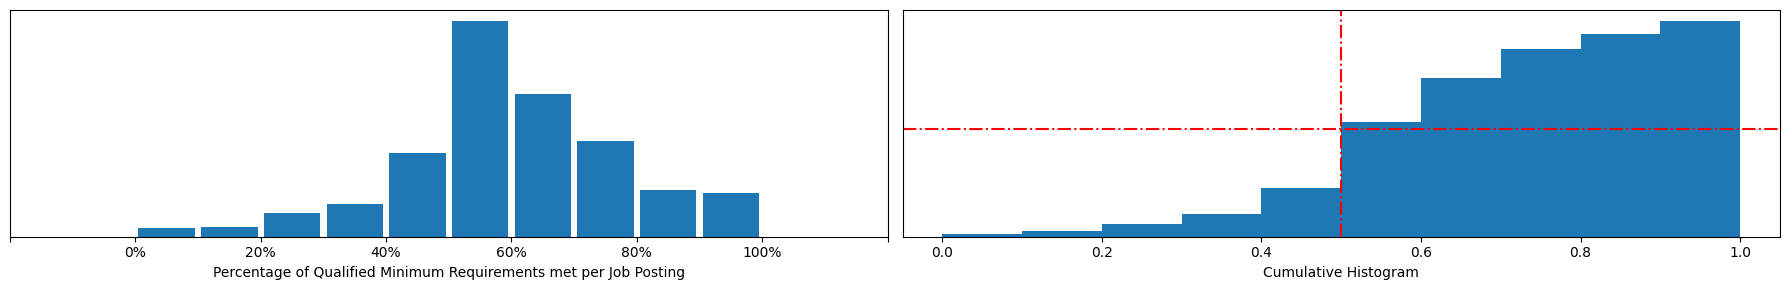

In [15]:

# Display as histogram
lru.display_hunting_dataframe_as_histogram()

# Show how long it took
# duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
# winsound.Beep(freq, duration)
# print(f'Minimum-requirements-met percentages estimated in {duration_str}')

# Restarting the kernel and getting to this cell takes 49 seconds, normally
# It takes 1 hour, 45 minutes and 13 seconds of you have to rebuild the LRs
cypher_str = f'''
    MATCH (fn:FileNames)
    WHERE
        (fn.percent_fit >= 0.8) AND
        ((fn.is_closed IS NULL) OR (fn.is_closed = false)) AND
        ((fn.is_opportunity_application_emailed IS NULL) OR (fn.is_opportunity_application_emailed = false))
    RETURN
        fn.percent_fit AS percent_fit,
        fn.file_name AS file_name,
        fn.posting_url AS posting_url
    ORDER BY fn.percent_fit DESC;'''
row_objs_list = []
with cu.driver.session() as session: row_objs_list = session.write_transaction(cu.do_cypher_tx, cypher_str)
if row_objs_list: display(DataFrame(row_objs_list))
# duration_str = humanize.precisedelta(time.time() - t0, minimum_unit='seconds', format='%0.0f')
# print(f'Restarting the kernel and getting to this cell took {duration_str}')

In [32]:

# Break up overly-long O-RQs:
# Ensure you have already displayed the context of an individual child string above
# Don't close the Notepad++ window until you have replaced the child string
def display_file_in_text_editor(file_name):
    text_editor_path = r'C:\Program Files\Notepad++\notepad++.exe'
    file_path = osp.abspath(osp.join(hau.SAVES_HTML_FOLDER, file_name))
    !"{text_editor_path}" "{file_path}"
display_file_in_text_editor(file_name)
cu.rebuild_filename_node(file_name, navigable_parent=None, verbose=True)
winsound.Beep(freq, duration)


                MATCH
                    (np:NavigableParents {navigable_parent: "<p>Target will provide reasonable accommodations with the application process upon your request as required to comply with applicable laws. If you have a disability and require assistance in this application process, please visit your nearest Target store or Supply Chain Facility or reach out to Guest Services at 1-800-440-0680 for additional information.</p>"}),
                    (ht:HeaderTags {header_tag: "p"})
                MERGE (ht)-[r:SUMMARIZES]->(np);


In [ ]:

# Remove this particular child string from the quals dictionary and database
basic_quals_dict = nu.load_object('basic_quals_dict')
child_str = child_strs_list[idx]
basic_quals_dict.pop(child_str, None)
# basic_quals_dict[child_str] = 0
nu.store_objects(basic_quals_dict=basic_quals_dict)
print(f'"{child_str}" in basic_quals_dict: {child_str in basic_quals_dict}')
def do_cypher_tx(tx, qualification_str, verbose=False):
    cypher_str = '''
        MATCH (qs:QualificationStrings {qualification_str: $qualification_str})
        DETACH DELETE qs;
        '''
    results_list = tx.run(query=cypher_str, parameters={'qualification_str': qualification_str})

    return [dict(record.items()) for record in results_list]
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(do_cypher_tx, qualification_str=child_str, verbose=False)

In [ ]:

# Remove file name from database
for file_name in ['']:
    cu.delete_filename_node(file_name, verbose=True)

In [161]:

import re

def separate_qualifications(quals_list):
  """
  This function takes a list of qualifications and separates them into individual sentences.

  Args:
      quals_list: A list of strings, where each string represents a qualification.

  Returns:
      A list of lists, where each inner list contains the individual qualifications extracted from the corresponding element in the original quals_list.
  """
  separated_quals = []
  for qual in quals_list:
    # Split qualifications based on commas, semicolons, and colons followed by whitespace
    split_quals = re.split(r", |; |:", qual)
    # Further split based on "and" if it's not the first word and there's punctuation before it
    for i, sentence in enumerate(split_quals):
      if i > 0 and re.search(r"\b(and)\b", sentence, flags=re.IGNORECASE) and re.search(r"[,\.;]", split_quals[i-1]):
        split_quals[i-1] += f" {sentence.strip()}"
        split_quals.pop(i)
    # Remove empty strings and leading/trailing whitespace
    separated_quals.append([q.strip() for q in split_quals if q.strip()])
  return separated_quals

separated_qualifications = separate_qualifications(quals_list)

# Print the separated qualifications
for qual_set in separated_qualifications:
  for qual in qual_set:
    print(qual)
  print()

Capacity to think critically about data
ask the right questions
make appropriate connections
and apply the right methodologies.

Basic knowledge of SQL for data querying and manipulation
working with database tools such as MySQL
Postgres
etc

Familiarity with big data platforms like Spark

Basic knowledge of version control systems like Git.

Ability to approach and solve problems logically and effectively.

This experience should demonstrate a foundation in data analysis techniques
basic statistical modeling
introductory machine learning concepts
and the application of these skills in real-world or academic projects to extract insights and understand data patterns

Strong verbal and written communication skills
including the ability to present complex findings to non-technical audiences.

Skills in managing time effectively
especially when handling multiple tasks or projects.

Ability to create informative and interpretable data visualizations using tools like Matplotlib
Seaborn
Bokeh